In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import adagrad
from scipy.stats import lognorm
import datetime


%matplotlib inline

In [2]:
df_train = pd.read_csv('final_train_day9.txt', index_col= False)
df_test = pd.read_csv('final_test_day9.txt', index_col = False)

In [144]:
# df_train.head()
# df_test.head()

,Unnamed: 0,time,source_user@domain,destination_user@domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success/failure,Malignant/Benign
0,1845582,714572,C15207$@DOM1,C15207$@DOM1,C15207,C529,Kerberos,Network,LogOn,Success,0
1,4516801,738252,C8743$@DOM1,C8743$@DOM1,C8743,C528,Kerberos,Network,LogOn,Success,0
2,1690337,712776,C1418$@DOM1,C1418$@DOM1,C1418,C586,Kerberos,Network,LogOn,Success,0
3,6983083,762654,NETWORK SERVICE@C11774,NETWORK SERVICE@C11774,C11774,C11774,Negotiate,Service,LogOn,Success,0
4,4550280,738540,C7856$@DOM1,C7856$@DOM1,C7856,C529,Kerberos,Network,LogOn,Success,0


In [11]:
def sep_x_y(df):
    features = list()
    for cols in df.columns:
        if cols != 'Malignant/Benign':
            features.append(cols)
    df_x = df[features]
    df_y = df['Malignant/Benign']
    
    return df_x, df_y
    
def split_user_domain(df):
    
    df['source_user'] = df['source_user@domain'].str.split('@').str[0]
    df['source_user'] = np.where(df['source_user'].str.contains('$'), df['source_user'].str.split('$').str[0],
                                df['source_user'])
    df['source_domain'] = df['source_user@domain'].str.split('@').str[1]
    
    df['destination_user'] = df['destination_user@domain'].str.split('@').str[0]
    df['destination_user'] = np.where(df['destination_user'].str.contains('$'), df['destination_user'].str.split('$').str[0],
                                     df['destination_user'])
    df['destination_domain'] = df['destination_user@domain'].str.split('@').str[1]
    
    return df

test_x_df_9 = df_test[df_test.columns[[0,1,2,3,4,5,7,8,9,10]]].values
test_y_df_9 = df_test['Malignant/Benign'].values


    
    
def drop_columns(df):
    
    df = df.drop(['Unnamed: 0','time', 'source_user@domain', 'destination_user@domain'], axis = 1)
    
    return df



def transform_data(df):
    from sklearn.preprocessing import LabelEncoder
    lb = LabelEncoder()
    for cols in df.columns:
        df[cols] = lb.fit_transform(df[cols])
    return df
    
def normalize(df):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    
    for cols in df.columns:
        df[cols] = MinMaxScaler(feature_range=(0,1)).fit_transform(df[cols].values.reshape(-1,1))
    return df

def df_to_array(df):
    df = df.values
    return df

def shape_to_3dim(df):
    """ This function changes the shape of the array for the LSTM -autoencoder."""
    df = df.reshape(df.shape[0], 1, df.shape[1])
    return df

def lstm_autoencoder(df_train_x, nb_epoch, batch_size):
    ## Creating the Model
    repeat_vector = df_train_x.shape[1]
    output_dim = df_train_x.shape[2] # number of features
    # nb_epoch = 5
    # batch_size = 64
    # input_dim = train_x.shape[1] #num of columns, 10
    # encoding_dim = 128
    # hidden_dim = int(encoding_dim / 2) #i.e. 2
    learning_rate = 1e-6
    autoencoder = Sequential()
    # Encoder
    autoencoder.add(LSTM(256, activation='relu', activity_regularizer=regularizers.l1(learning_rate),return_sequences=True))
    autoencoder.add(LSTM(128, activation='sigmoid', activity_regularizer=regularizers.l2(learning_rate),return_sequences=False))
    autoencoder.add(Dense(64, activation = 'softmax'))
    autoencoder.add(Dropout(0.2))
    autoencoder.add(Dense(32, activation = 'relu'))
    autoencoder.add(Dropout(0.2))
    autoencoder.add(Dense(16, activation='sigmoid'))
    autoencoder.add(RepeatVector(repeat_vector))

    # Decoder
    autoencoder.add(Dense(16, activation='sigmoid'))
    autoencoder.add(Dense(32, activation='relu'))
    autoencoder.add(Dense(64, activation= 'sigmoid'))
    autoencoder.add(LSTM(128, activation='sigmoid', activity_regularizer=regularizers.l2(learning_rate),return_sequences=True))
    autoencoder.add(LSTM(256, activation='relu', activity_regularizer=regularizers.l1(learning_rate),return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(output_dim)))

    # Model Compiler
    opt = adagrad(lr = 1e-3, decay = 1e-5)

    autoencoder.compile(metrics=['accuracy'],
                        loss='mean_squared_error',
                        optimizer= opt)
    autoencoder.fit(df_train_x, df_train_x, epochs=nb_epoch, 
                              batch_size = batch_size, shuffle = True, verbose = 0)
    return autoencoder


def lstm_testing(autoencoder, df_test_x):
    
    predictions = autoencoder.predict(df_test_x)
       
    return predictions

def create_df_for_predictions(predictions, df_test_x, df_test_y):
    
    df_test_x = df_test_x.reshape(df_test_x.shape[0], df_test_x.shape[2])
    predictions = predictions.reshape(predictions.shape[0], predictions.shape[2])
    
    mse = np.mean(np.power(df_test_x - predictions, 2), axis=1)

    error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': df_test_y})
    
    return error_df

def set_threshold(normal, abnormal):
    
    # Get the parameter estimates
    shape_normal, loc_normal, scale_normal = lognorm.fit(normal, floc=0)
    shape_abnormal, loc_abnormal, scale_abnormal = lognorm.fit(abnormal, floc=0)

    mu_normal, sigma_normal = np.log(scale_normal) , shape_normal # Has to be transformed, see documentation
    mu_abnormal, sigma_abnormal = np.log(scale_abnormal) , shape_abnormal
    
    grid_min, grid_max = np.min(normal), np.max(abnormal)
    grid = np.arange(grid_min, grid_max, 0.001)
    
    y_normal = lognorm.pdf(grid, sigma_normal, 0, np.exp(mu_normal))
    y_abnormal = lognorm.pdf(grid, sigma_abnormal, 0, np.exp(mu_abnormal))
    
    idx = np.argwhere(np.diff(np.sign(y_normal - y_abnormal))).flatten()
    
    candidates = 0
    
    for x in idx:
        if (y_normal[x-1] > y_normal[x]) and (y_abnormal[x-1] < y_abnormal[x]):
            res = grid[x]
            candidates += 1
    if candidates == 0:
        print("Warning: No good threshold found")
        res = grid[idx[0]]
            
    return res


def next_threshold(current_threshold, new_losses):
    # Update the threshold based on the new losses (new chunk of losses)
    
    # New normal and abnormal data based on current threshold
    normal_new = new_losses[new_losses <= current_threshold]
    abnormal_new = new_losses[new_losses > current_threshold]
    
    pred = np.zeros(len(new_losses))
    pred[new_losses > current_threshold] = 1
    
    # Append to normals/abnormals from "ground_truth"
    normal_total = np.append(normal, normal_new)
    abnormal_total = np.append(abnormal, abnormal_new)
    
    new_threshold = set_threshold(normal_total, abnormal_total)

    return new_threshold, pred


def create_chunks(losses, chunk_size):
    # Create chunks of some size
    for i in range(0, len(losses), chunk_size):
        yield losses[i:i+chunk_size]
        
        
def online_pred(init_threshold, losses, chunk_size):
    # init_threshold: The initial threshold of set_threshold(normal, abnormal) using "ground truth" for normal and abnormal
    # losses: the new losses we apply this prediction method on, has to be np.array
    # chunk_size: chunk sizes of the losses
    
    # Output: the normal/abnormal predictions based on the losses and this method + thresholds
    
    chunks = list(create_chunks(losses, chunk_size))
    
    current_threshold = init_threshold
    pred = np.empty((0,))
    thresholds = []
    
    for i in range(len(chunks)):
        val = next_threshold(current_threshold, chunks[i])
        
        current_threshold = val[0]
        pred_of_chunk = val[1]
        pred = np.append(pred, pred_of_chunk)
        thresholds.append(current_threshold)
    
    return pred, thresholds

    

In [12]:
print(datetime.datetime.now().time())
df_train.head()
df_train = split_user_domain(df_train)

df_train = transform_data(df_train)

df_train = normalize(df_train)

df_train = drop_columns(df_train)

df_train_x, df_train_y = sep_x_y(df_train)

df_train_x = df_to_array(df_train_x)

df_train_x = shape_to_3dim(df_train_x)

df_test = split_user_domain(df_test)
df_test = transform_data(df_test)
df_test = normalize(df_test)
df_test = drop_columns(df_test)
df_test_1 = df_test[:10200]
df_test_1_x, df_test_1_y = sep_x_y(df_test_1)
df_test_1_x = df_to_array(df_test_1_x)
df_test_1_x = shape_to_3dim(df_test_1_x)

df_test_2 = df_test[10200:20400]
df_test_2_x, df_test_2_y = sep_x_y(df_test_2)
df_test_2_x = df_to_array(df_test_2_x)
df_test_2_x = shape_to_3dim(df_test_2_x)


16:15:48.790264


In [13]:
autoencoder = lstm_autoencoder(df_train_x, 5, 128)
print(datetime.datetime.now().time())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
16:17:44.260520


In [14]:
print(datetime.datetime.now().time())
predictions = lstm_testing(autoencoder, df_test_1_x)
print(datetime.datetime.now().time())

16:24:42.682940
16:24:45.705495


In [15]:
error_df = create_df_for_predictions(predictions, df_test_1_x, df_test_1_y)

In [16]:
normal = error_df['reconstruction_error'][error_df.true_class == 0].values
abnormal =  error_df['reconstruction_error'][error_df.true_class == 1].values



In [ ]:
# import pandas as pd
# from scipy.stats import lognorm

# labels = pd.read_csv('Training_Test_day_9_labels.txt')
# labels = labels.iloc[:,0].values
# labels = labels[30000:]
# losses = pd.read_csv('Training_Test_day_9_losses.txt')
# losses = losses.iloc[:,0].values

In [18]:
## Implement the method

# Set initial threshold
init_threshold = set_threshold(normal, abnormal)

predictions_2 = lstm_testing(autoencoder, df_test_2_x)
error_df_2 = create_df_for_predictions(predictions_2, df_test_2_x, df_test_2_y)
loss_new = error_df_2['reconstruction_error'].values

# If no good threshold found in a chunk it will output a warning message
pred, thresholds = online_pred(init_threshold = init_threshold, losses = loss_new, chunk_size = 10200) 

# thresholds = online_pred(init_threshold = init_threshold, losses = loss_new, chunk_size = 1000)[1]

In [194]:
init_threshold,thresholds

(0.05934827464391011, [0.05584268864000531])

In [26]:
# Evaluation of the predictions

TP = np.sum((pred == 1)&(df_test_1_y == 1))
FP = np.sum((pred == 1)&(df_test_1_y == 0))
TN = np.sum((pred == 0)&(df_test_1_y == 0))
FN = np.sum((pred == 0)&(df_test_1_y == 1))

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(TN+FP)
FNR = FN/(FN+TP)


accuracy = (TP+TN)/(TP+FN+FP+TN)
sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)
precision = TP/(TP+FP) 

print ("TPR: ", np.round(TPR, 4), 
       "; FPR: ", np.round(FPR, 4),
       "; TNR: ", np.round(TNR, 4),
       "; FNR: ", np.round(FNR, 4))

print ("Accuracy: ", np.round(accuracy, 4), 
       "; Sensitivity: ", np.round(sensitivity, 4),
       "; Specificity: ", np.round(specificity, 4),
       "; Precision: ", np.round(precision, 4))

print("TP:",TP, "FP:",FP, "TN:",TN, "FN:",FN)

TPR:  1.0 ; FPR:  0.2713 ; TNR:  0.7287 ; FNR:  0.0
Accuracy:  0.734 ; Sensitivity:  1.0 ; Specificity:  0.7287 ; Precision:  0.0687
TP: 200 FP: 2713 TN: 7287 FN: 0


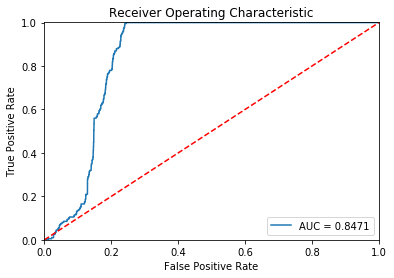

In [196]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


In [137]:
# df_9 = pd.read_csv('auth_day_9_labelled.txt', header = None)
# red_team = pd.read_csv('redteam1.txt', header = None)
# red_team['Malignant/Benign'] = 1

# df_9.columns = ["time","source_user@domain","destination_user@domain","source_computer","destination_computer",
#               "authentication_type","logon_type","authentication_orientation","success/failure", "Malignant/Benign"]

# red_team.columns = ["time","source_user@domain","destination_user@domain","source_computer","destination_computer",
#               "authentication_type","logon_type","authentication_orientation","success/failure", "Malignant/Benign"]

# df_9_normal = df_9[df_9['Malignant/Benign'] == 0]
# # df_9_mal = df_9[df_9['Malignant/Benign'] == 1]


# df_9_normal = df_9_normal.sample(len(df_9_normal))
# red_team = red_team.sample(len(red_team))

# # df_9_normal = df_9_normal.iloc[:40000]
# # df_9_mal = df_9_mal.iloc[:200]


# # df_9 = df_9_normal.append(df_9_mal)

# df_train = df_9_normal.iloc[:30000]

# df_test = df_9_normal.iloc[30000:40000].append([red_team.iloc[:200], df_9_normal.iloc[40000:50000],
#                                               red_team.iloc[200:400], df_9_normal.iloc[50000:60000],
#                                               red_team.iloc[400:600], df_9_normal.iloc[60000:70000],
#                                               red_team.iloc[600:]])
                                              



In [141]:
# # len(red_team.iloc[600:])
# # len(red_team)
# # len(df_test)

# df_train.to_csv('final_train_day9.txt')
# df_test.to_csv('final_test_day9.txt')